In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

from numpy.random import rand

In [2]:
n = 10
points = rand(n, 2)
values = rand(n)

In [3]:
def infer_bounds(points):
  mins = np.min(points, axis=0)
  maxs = np.max(points, axis=0)
  return mins[0], maxs[0], mins[1], maxs[1]

In [4]:
def grid(bounds, num_points=100):
  xs = np.linspace(bounds[0], bounds[1], num=num_points)
  ys = np.linspace(bounds[2], bounds[3], num=num_points)
  return tuple(np.meshgrid(xs, ys))

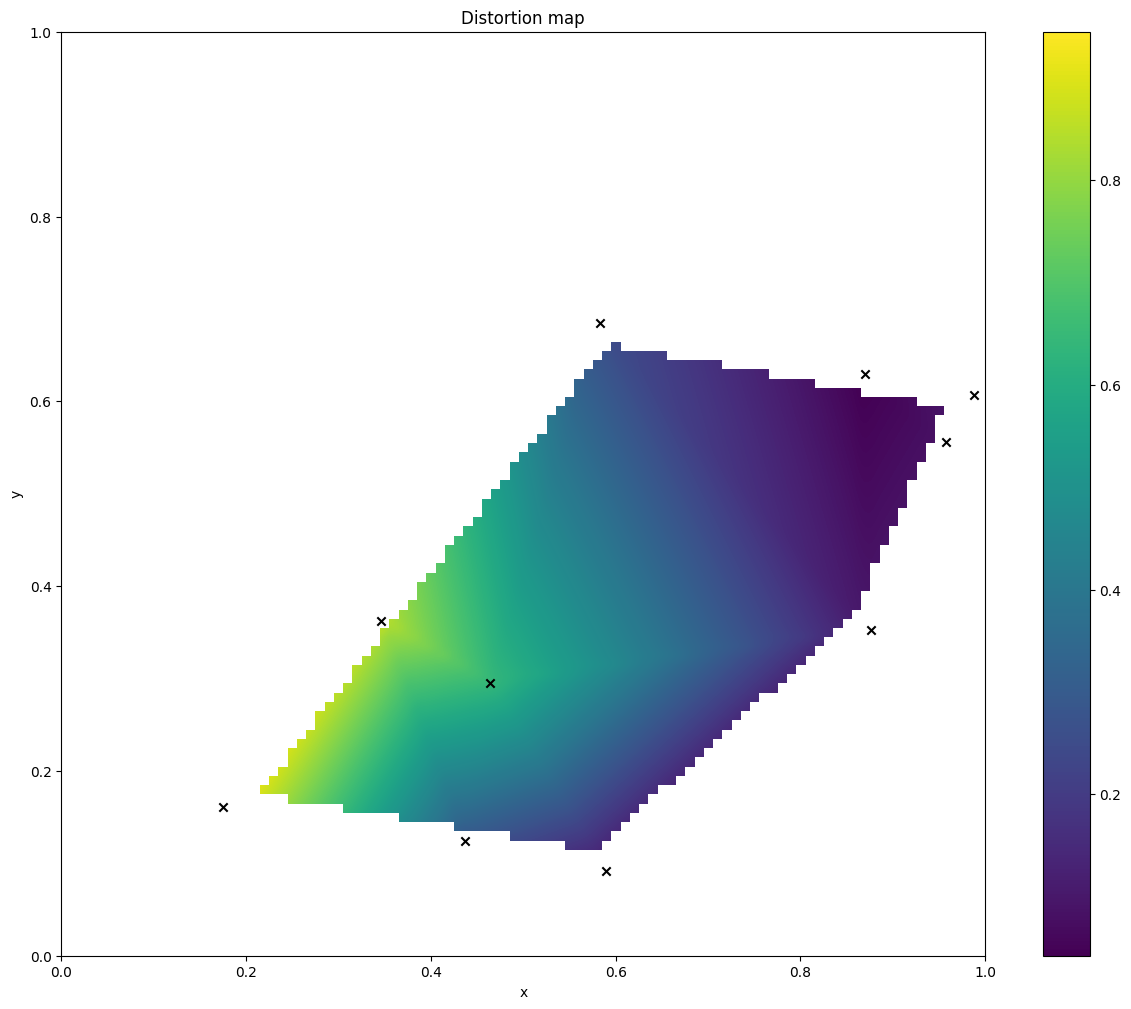

In [5]:
def plot_distortion(points, values, bounds=None, method='linear'):
  if bounds is None:
    bounds = infer_bounds(points)
  data = griddata(points, values, grid(bounds), method=method)
  
  plt.title('Distortion map')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.scatter(points[:, 0], points[:, 1], c="black", marker='x')
  plt.imshow(data, origin='lower', extent=bounds, interpolation='spline16')
  plt.colorbar()


plt.figure(figsize=(15, 12))
plot_distortion(points, values, bounds=(0, 1, 0, 1))
plt.show()

In [6]:
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.neighbors import kneighbors_graph

import networkx as nx

In [7]:
iris = datasets.load_iris()
X = iris.data
n, _ = X.shape

In [8]:
def find_min_k(X):
  def check(k):
    g = nx.Graph(kneighbors_graph(X, n_neighbors=k))
    return nx.is_connected(g)

  for k in range(1, X.shape[0]):
    if check(k):
      return k

In [9]:
k = find_min_k(X)
g = nx.Graph(kneighbors_graph(X, n_neighbors=k, mode='distance'))
pred, _ = nx.floyd_warshall_predecessor_and_distance(g)

In [10]:
def shortest_paths(X):
  k = find_min_k(X)
  print(f'Min K found: {k}')
  g = nx.Graph(kneighbors_graph(X, n_neighbors=k, mode='distance'))
  return nx.floyd_warshall_predecessor_and_distance(g)

In [11]:
preds_h, dists_h = shortest_paths(X)

Min K found: 25


In [12]:
X_low = PCA(n_components=2).fit_transform(X)
X_low[:5]

array([[-2.68412563,  0.31939725],
       [-2.71414169, -0.17700123],
       [-2.88899057, -0.14494943],
       [-2.74534286, -0.31829898],
       [-2.72871654,  0.32675451]])

In [13]:
preds_l, dists_l = shortest_paths(X_low)

Min K found: 27


In [14]:
def distance_matrix(dists):
  n = len(dists)
  return np.array([[dists[i][j] for j in range(n)] for i in range(n)])

In [15]:
def distortion_matrix(dists_h, dists_l):
  mh = distance_matrix(dists_h)
  ml = distance_matrix(dists_l)
  ml[ml == 0] = np.nextafter(0, 1)
  return mh / ml
def distortion_coef(M):
  return m.mean(axis=0)

m = distortion_matrix(dists_h, dists_l)
coeffs = distortion_coef(m)

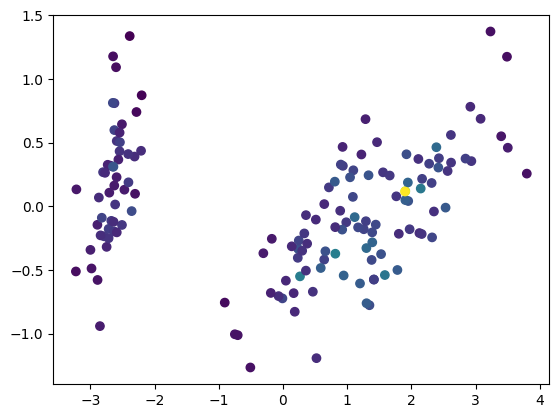

In [16]:
plt.scatter(X_low[:, 0], X_low[:, 1], c = coeffs)
plt.show()

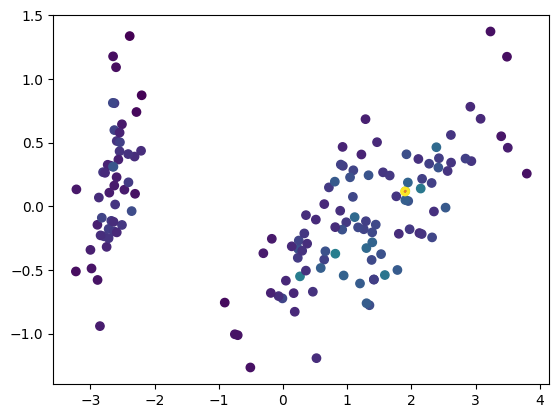

In [17]:

def build_path(first, last, connectivity_m):
    path = np.array([X_low[first]])
    head = first
    prev_head = last
    while head!=last:
        head = connectivity_m[last][head]
        path = np.concatenate((path, [X_low[head]]))
    return path
path_l = build_path(115, 148, preds_l)
path_h = build_path(115, 148, preds_h)
plt.plot(path_h[:, 0], path_h[:, 1])
plt.plot(path_l[:, 0], path_l[:, 1])
plt.scatter(X_low[:, 0], X_low[:, 1], c = coeffs)
plt.show()

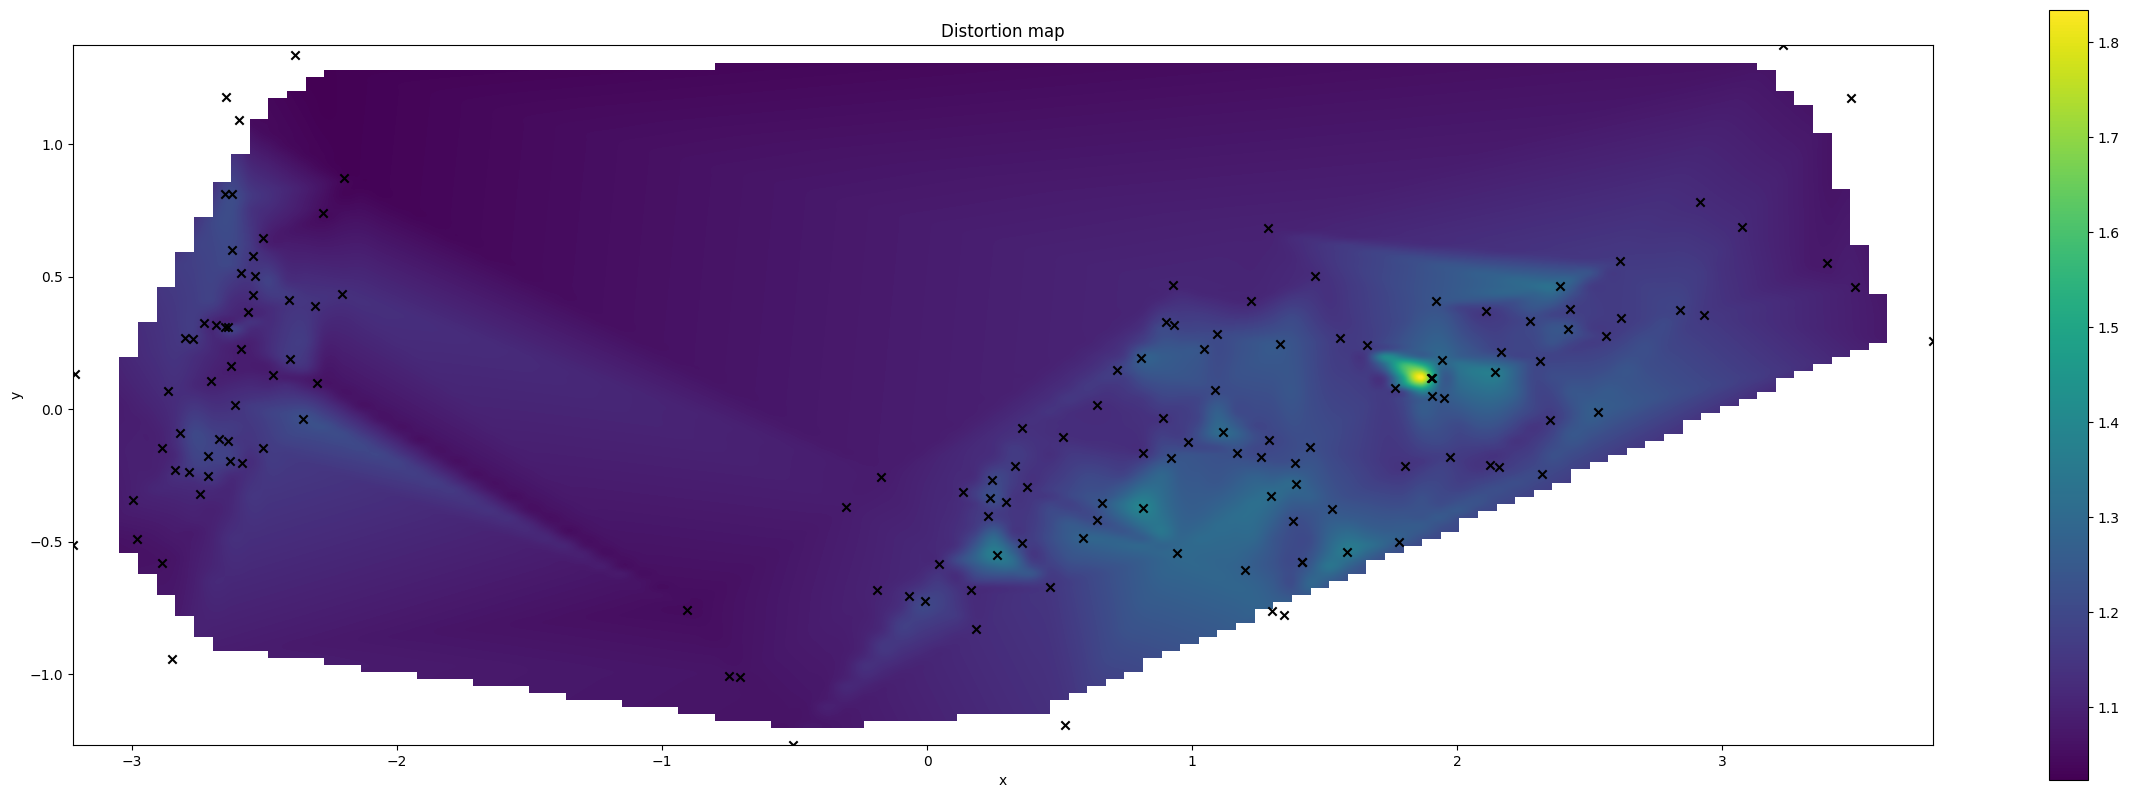

In [18]:
plt.figure(figsize=(30, 10))
plot_distortion(X_low, coeffs, method='linear')
plt.show()

What's that bright spot?

In [19]:
np.argmax(coeffs > 1.8)

148

In [27]:
print(m[148, :])
m[148, :].argmax()

[ 1.03957852  1.0783575   1.07457562  1.08486932  1.04331407  1.02086657
  1.08072911  1.05431854  1.08029571  1.08562344  1.04252602  1.08301664
  1.07945354  1.07199077  1.02737495  1.02210008  1.03587755  1.03434847
  1.01762934  1.03712956  1.04413587  1.03301577  1.06584789  1.01477909
  1.1523492   1.10039598  1.04466593  1.03690725  1.04243146  1.08523437
  1.08447128  1.03019032  1.04815143  1.03423512  1.07832108  1.06953374
  1.03704428  1.05864369  1.07992619  1.04779495  1.04010518  1.07775576
  1.08216516  1.05184064  1.05283359  1.07132532  1.05852239  1.0835723
  1.04181927  1.05563634  1.71083152  1.44493075  2.11518053  1.16913739
  1.65357153  1.16423481  1.41518045  1.05610254  1.78008707  1.05556337
  1.10200032  1.08822593  1.31880775  1.3299301   1.06680902  1.49780513
  1.06748956  1.17741949  1.54633836  1.15315196  1.03455325  1.19209488
  1.89426782  1.44009168  1.46220136  1.54578381  2.38971364  2.61721853
  1.18017747  1.11417483  1.13958727  1.13200011  1.

115

In [20]:
m[148][115]

68.40785035941643

In [21]:
dists_h[148][115], dists_l[148][115]

(0.3000000000000001, 0.004385461586993206)

In [22]:
nx.reconstruct_path(148, 115, preds_h), nx.reconstruct_path(148, 115, preds_l)

([148, 115], [148, 115])

In [23]:
from sklearn.metrics.pairwise import euclidean_distances

print(euclidean_distances(X[148, :].reshape(1, 4), X[115, :].reshape(1, 4)))
print(euclidean_distances(X_low[148, :].reshape(1, 2), X_low[115, :].reshape(1, 2)))

[[0.3]]
[[0.00438546]]


Everything checks out...

In [24]:
def run_experiment(X, X_low):
  print(f'Original shape: {X.shape}')
  preds_h, dists_h = shortest_paths(X)

  print(f'Lowered shape: {X_low.shape}')
  preds_l, dists_l = shortest_paths(X_low)

  m = distortion_matrix(dists_h, dists_l)
  coeffs = m.mean(axis=0)

  plt.figure(figsize=(30, 10))
  plot_distortion(X_low, coeffs, method='linear')
  plt.show()

Original shape: (150, 4)
Min K found: 25
Lowered shape: (150, 2)
Min K found: 27


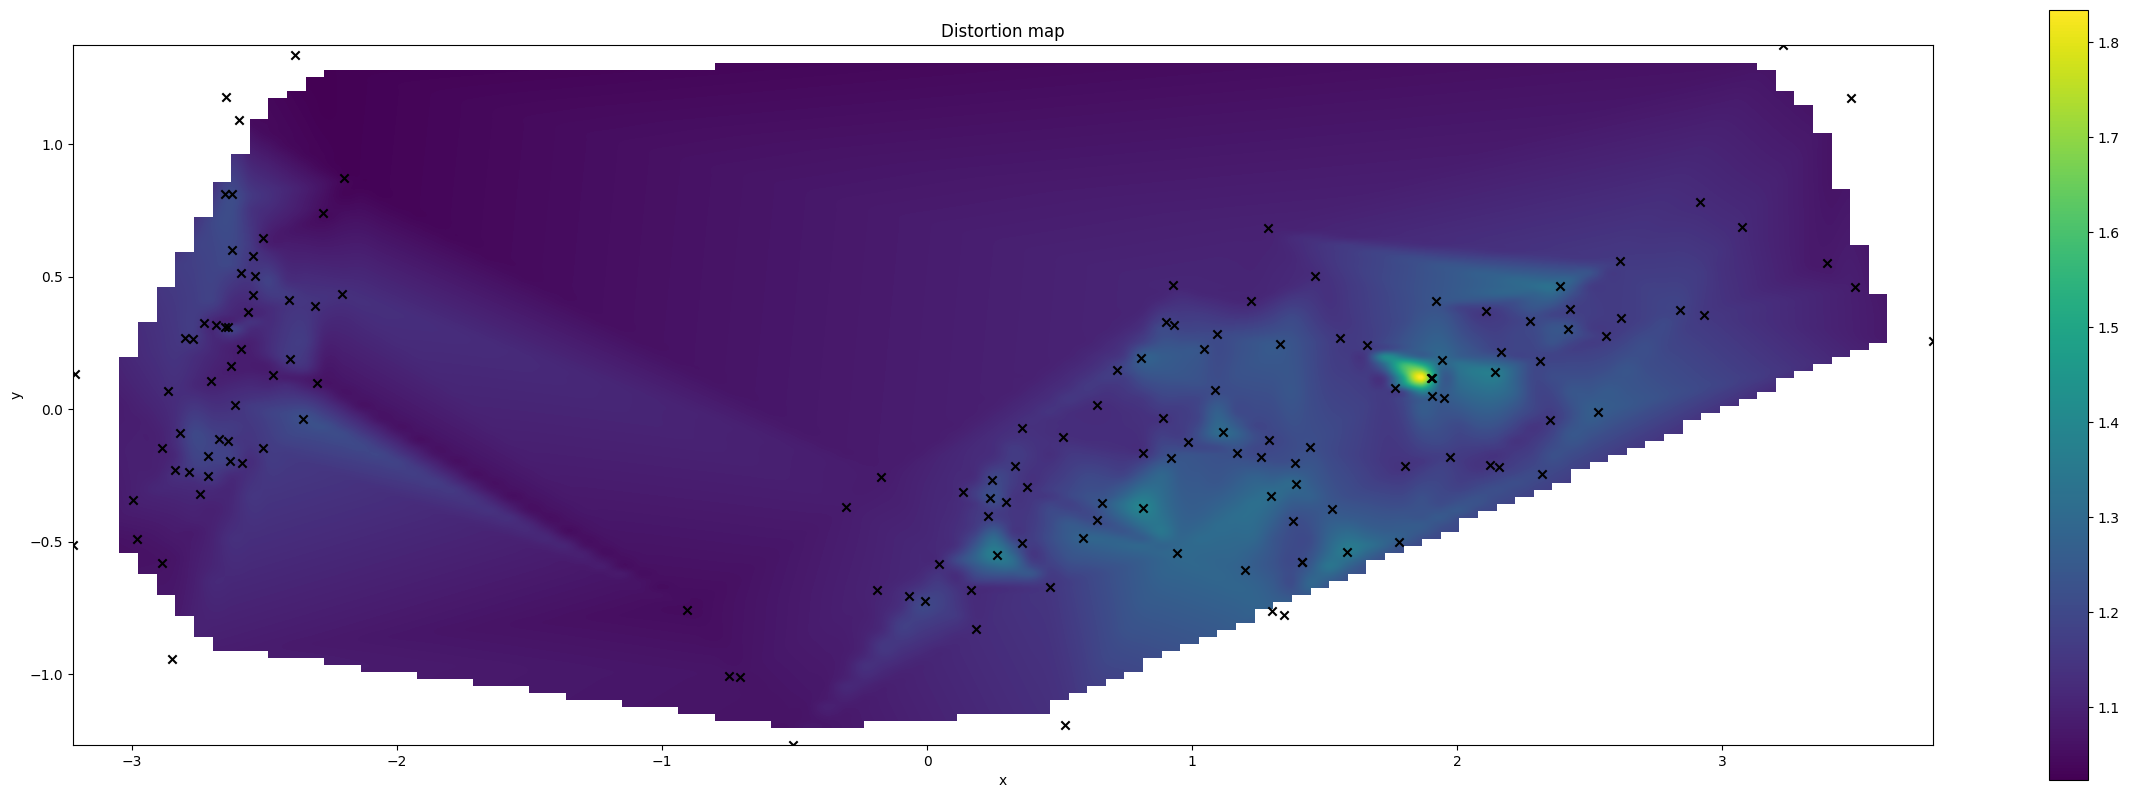

In [25]:
run_experiment(X, X_low)

Now, let's try bigger dataset

In [9]:
bc = datasets.load_breast_cancer()
X = bc.data
X[:5]

array([[1.799e+01, 1.038e+01, 1.228e+02, 1.001e+03, 1.184e-01, 2.776e-01,
        3.001e-01, 1.471e-01, 2.419e-01, 7.871e-02, 1.095e+00, 9.053e-01,
        8.589e+00, 1.534e+02, 6.399e-03, 4.904e-02, 5.373e-02, 1.587e-02,
        3.003e-02, 6.193e-03, 2.538e+01, 1.733e+01, 1.846e+02, 2.019e+03,
        1.622e-01, 6.656e-01, 7.119e-01, 2.654e-01, 4.601e-01, 1.189e-01],
       [2.057e+01, 1.777e+01, 1.329e+02, 1.326e+03, 8.474e-02, 7.864e-02,
        8.690e-02, 7.017e-02, 1.812e-01, 5.667e-02, 5.435e-01, 7.339e-01,
        3.398e+00, 7.408e+01, 5.225e-03, 1.308e-02, 1.860e-02, 1.340e-02,
        1.389e-02, 3.532e-03, 2.499e+01, 2.341e+01, 1.588e+02, 1.956e+03,
        1.238e-01, 1.866e-01, 2.416e-01, 1.860e-01, 2.750e-01, 8.902e-02],
       [1.969e+01, 2.125e+01, 1.300e+02, 1.203e+03, 1.096e-01, 1.599e-01,
        1.974e-01, 1.279e-01, 2.069e-01, 5.999e-02, 7.456e-01, 7.869e-01,
        4.585e+00, 9.403e+01, 6.150e-03, 4.006e-02, 3.832e-02, 2.058e-02,
        2.250e-02, 4.571e-03, 2.357e

In [35]:
X_low = PCA(n_components=2).fit_transform(X)
X_low[:5]

array([[1160.1425737 , -293.91754364],
       [1269.12244319,   15.63018184],
       [ 995.79388896,   39.15674324],
       [-407.18080253,  -67.38031982],
       [ 930.34118015,  189.34074158]])

Original shape: (569, 30)
Min K found: 4
Lowered shape: (569, 2)
Min K found: 4


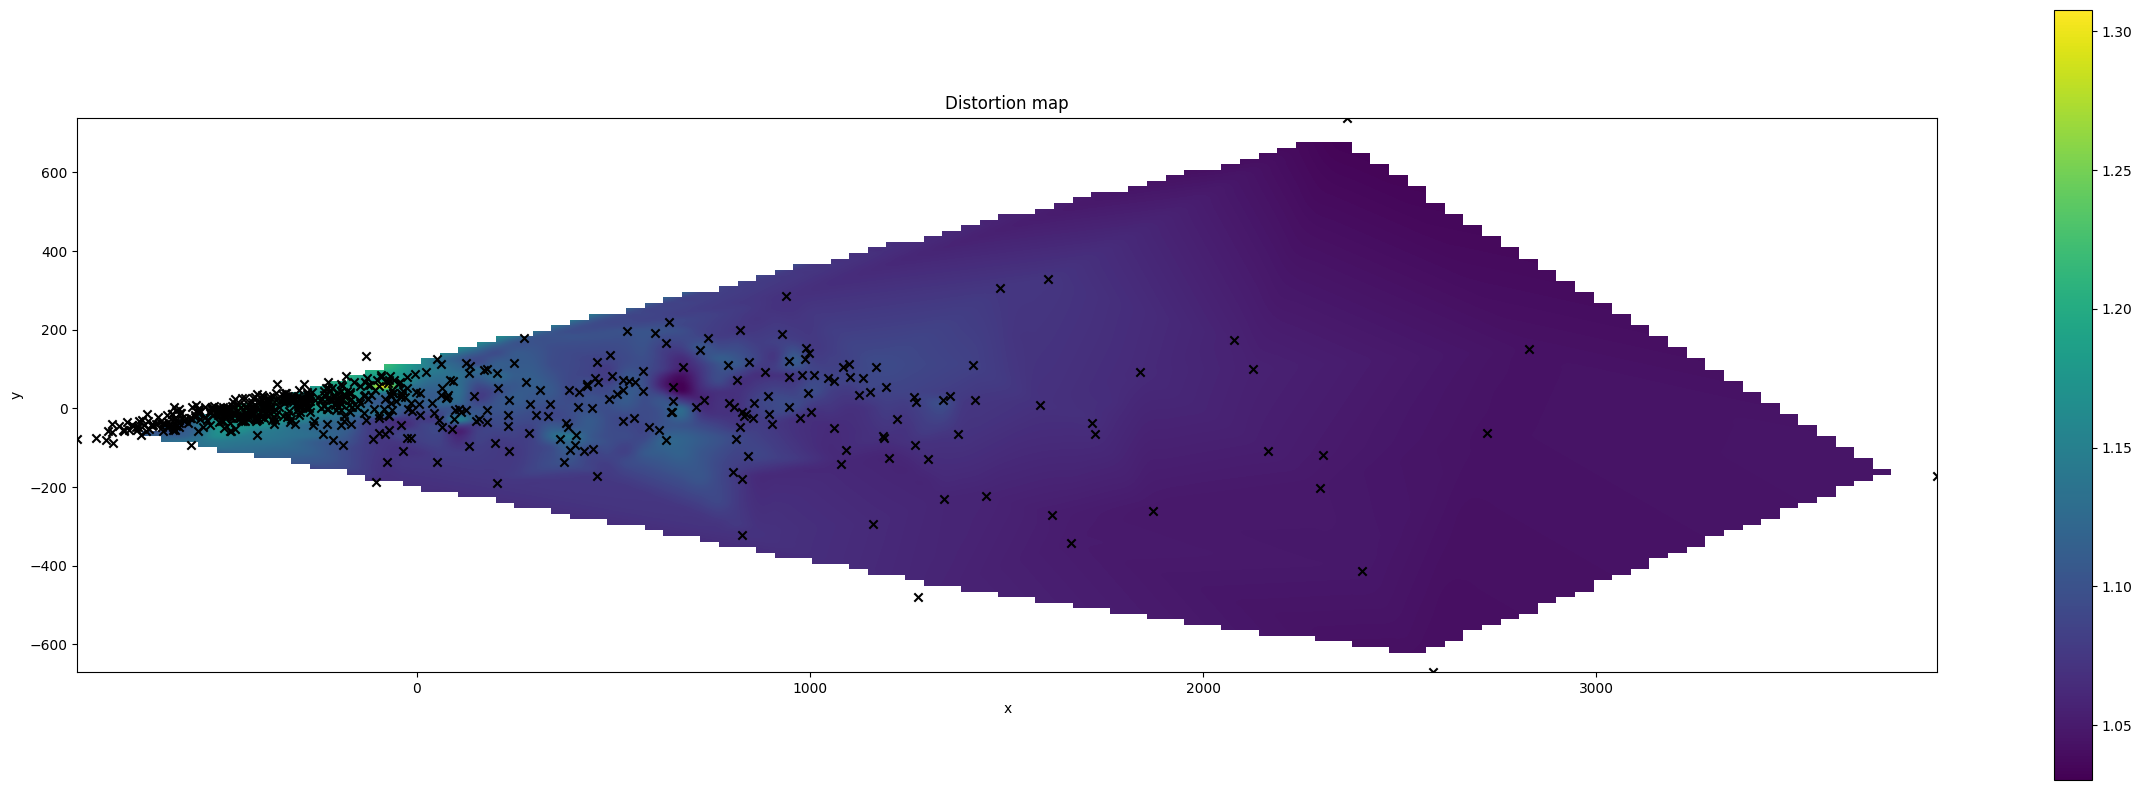

In [36]:
run_experiment(X, X_low)

That took a while to compute...

Breaking down performance:
* Finding min-k takes O(NlogN)
* Graph construction takes O(N^2)
* Floyd-Warshall runs in O(N^3)
* Distortion matrix is computed in O(N^2)

It's easy to see that total complexity is dominated by Floyd-Warshall which for O(1000) nodes should run in seconds. Unfortunatelly Python is slow and it takes many minutes even for 600 nodes.

Technically we can implement Floyd-Warshall in C++ or Cython and it should be able to scale to O(1k) datasets. Going further requires dropping exact shortest distances and approximating them somehow (heuristic? A*?)

In [1]:
from source.DRD import DRD 

In [2]:

from sklearn import datasets
iris = datasets.load_iris(as_frame=True)
X = iris.data
exp1 = DRD()
exp1.set_matrix(X, X.index.values)
exp1.ReduceDimensionalityPCA()
exp1.run_experiment()


Original shape: (150, 4)
Min K found: 25
Lowered shape: (150, 2)
Min K found: 27


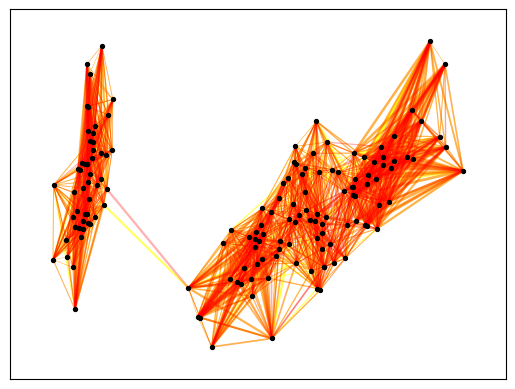

In [9]:
exp1.plot_graph()

In [2]:
exp1.set_matrix(X, X.index.values)
exp1.ReduceDimensionalitySVD()
exp1.run_experiment()

Original shape: (150, 4)
Min K found: 25
Lowered shape: (150, 2)
Min K found: 28


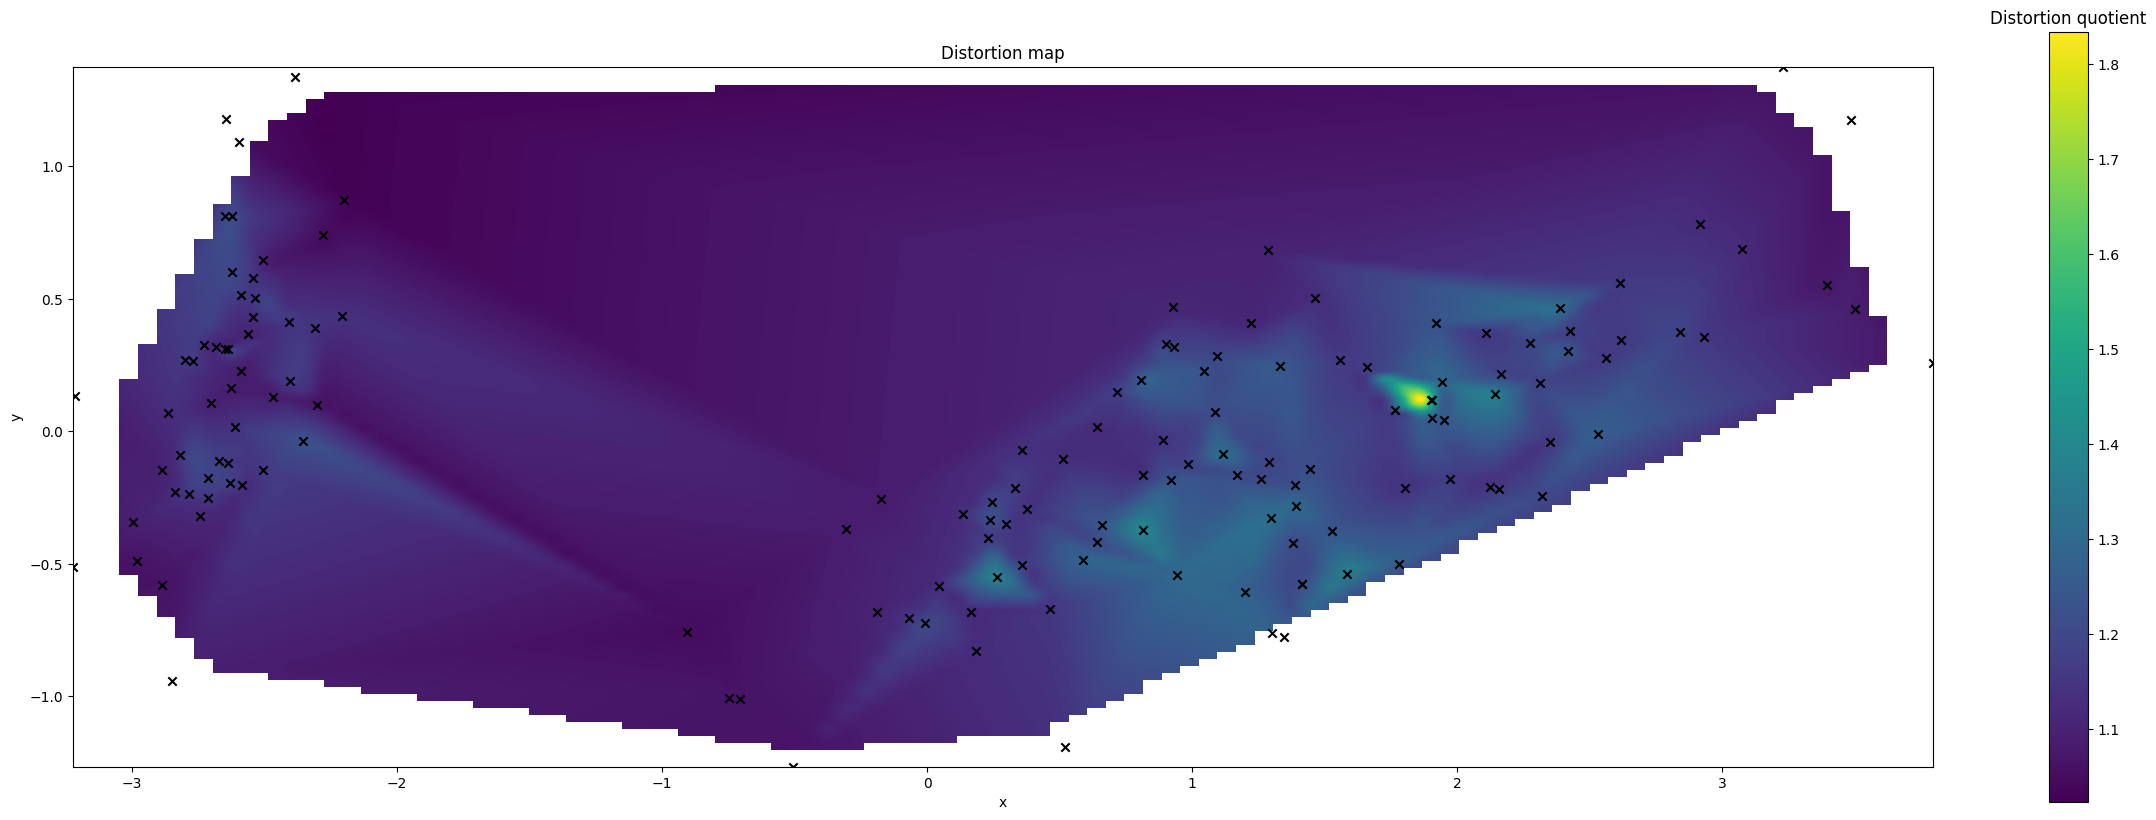

In [3]:
exp1.plot_distortion()

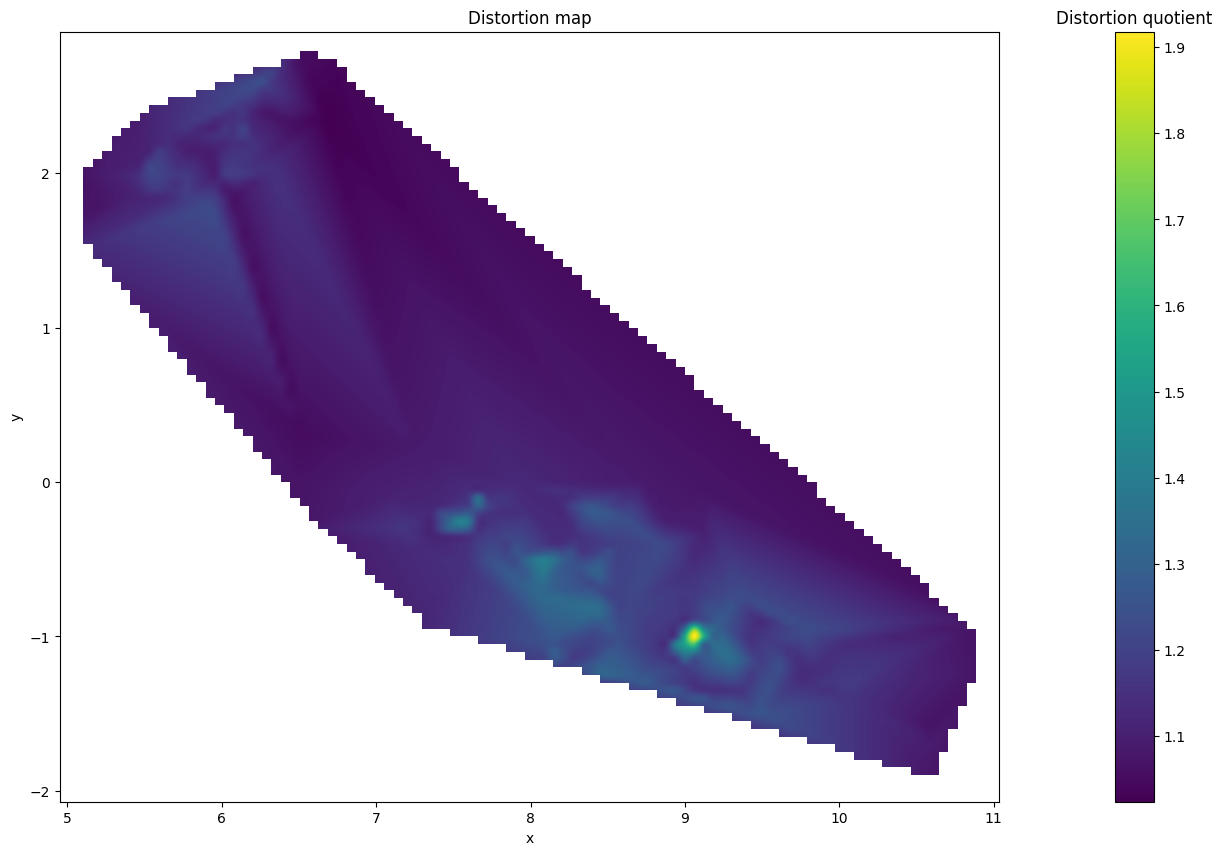

In [4]:
exp1.plot_distortion(points=False, gradient= True)

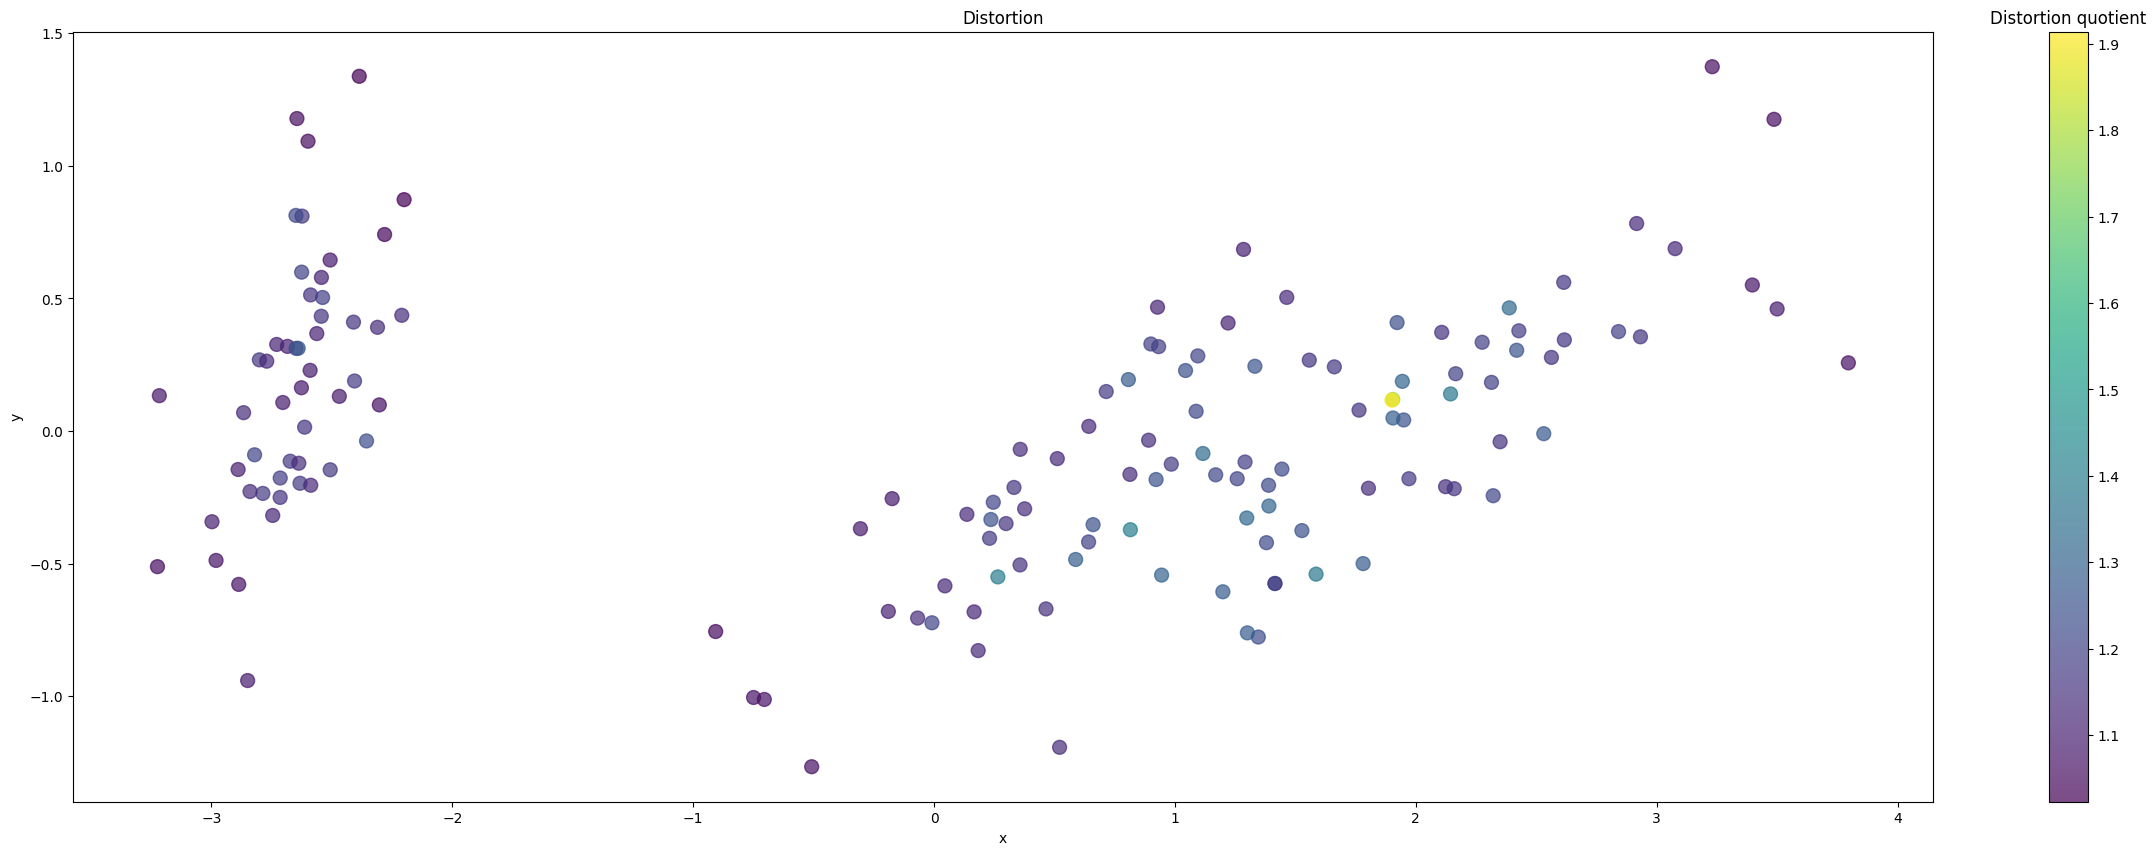

In [3]:
exp1.plot_distortion(points=True, gradient= False, color_points= True)

In [10]:
exp1.interactive_plot(True)

    'data': [{'hovertext': [ID: 0, ID: 1, ID: 2, ID: 3, ID: 4, ID…

In [23]:
df.head()

,aircraft,helicopter,tank,APC,field artillery,MRL,military auto,fuel tank,drone,naval ship,anti-aircraft warfare,special equipment,mobile SRBM system,vehicles and fuel tanks,cruise missiles
day,,,,,,,,,,,,,,,
2,10,7,80,516,49,4,100,60,0,2,0,0,0,0,0
3,17,19,66,190,0,0,30,0,2,0,0,0,0,0,0
4,0,0,4,0,1,0,0,0,0,0,0,0,0,0,0
5,2,3,0,110,24,17,161,0,1,0,5,0,0,0,0
6,0,0,48,30,3,3,14,0,0,0,2,0,0,0,0


In [21]:
import pandas as pd
df = pd.read_csv('russia_losses_equipment.csv', sep=',')
df = df.drop(['date', 'greatest losses direction'], axis=1)
df = df.set_index(['day'])
df = df.diff().fillna(df).fillna(0).astype(int)
exp2 = DRD()
exp2.set_matrix(df, df.index.values)
exp2.ReduceDimensionalityPCA()
exp2.run_experiment()

Original shape: (318, 15)
Min K found: 6
Lowered shape: (318, 2)
Min K found: 4


In [22]:
exp2.interactive_plot(True, df.index.values)

    'data': [{'hovertext': [ID: 2, ID: 3, ID: 4, ..., ID: 317, ID…

In [154]:
df.iloc[260:276]

,aircraft,helicopter,tank,APC,field artillery,MRL,military auto,fuel tank,drone,naval ship,anti-aircraft warfare,special equipment,mobile SRBM system,vehicles and fuel tanks,cruise missiles
day,,,,,,,,,,,,,,,
262,0,0,24,34,12,0,0,0,1,0,0,1,0,20,0
263,0,0,2,12,8,0,0,0,1,0,1,0,0,16,0
264,0,0,8,6,2,0,0,0,2,0,0,0,0,21,0
265,0,0,13,25,11,0,0,0,2,0,2,0,0,35,0
266,0,0,10,24,10,0,0,0,14,0,1,0,0,9,75
267,0,0,7,7,0,0,0,0,6,0,0,0,0,2,0
268,0,0,1,4,5,0,0,0,5,0,0,1,0,4,6
269,0,0,6,7,2,0,0,0,0,0,0,0,0,2,0
270,0,0,1,2,1,0,0,0,1,0,0,0,0,3,0


In [153]:
df.iloc[62:70]

,aircraft,helicopter,tank,APC,field artillery,MRL,military auto,fuel tank,drone,naval ship,anti-aircraft warfare,special equipment,mobile SRBM system,vehicles and fuel tanks,cruise missiles
day,,,,,,,,,,,,,,,
64,2,0,31,47,10,2,22,0,8,0,1,0,0,0,0
65,2,0,16,29,4,0,7,0,14,0,1,0,0,0,0
66,1,0,22,27,1,0,6,0,3,0,4,1,0,0,0
67,2,0,18,26,15,0,0,0,13,0,3,0,0,1796,84
68,2,0,22,48,8,1,0,0,26,0,0,6,0,28,0
69,0,0,14,48,16,10,0,0,20,2,0,0,0,19,0
70,0,0,15,43,16,1,0,0,12,0,1,0,0,24,3
71,2,0,15,41,8,6,0,0,9,0,2,0,0,40,2
